In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

import os
import re
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from collections import deque
from tqdm import tqdm,tqdm_notebook

import util
import data

warnings.filterwarnings('ignore')

sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

# setting
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]='0'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyper-parameters 
input_size = 784
channels = [1,32,64,64]
fc_size = 512
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-2

# Directory
parent_dir = os.path.join('runs','aa')
log_dir = os.path.join(parent_dir, 'log')
ckpt_dir = os.path.join(parent_dir, 'ckpt')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [3]:
train_loader, test_loader = data.mnist_dataset(batch_size)
_, test_loader_f = data.fashion_mnist_dataset(batch_size)
_, test_loader_not = data.not_mnist_dataset(459)

File F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is broken
File A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is broken


In [4]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(channels[0], channels[1], 5, padding=2)
        self.conv2 = nn.Conv2d(channels[1], channels[2], 5, padding=2)
        self.conv3 = nn.Conv2d(channels[2], channels[3], 5, padding=2)
        self.fc1 = nn.Linear(channels[3]*4*4, fc_size)
        self.fc2 = nn.Linear(fc_size, num_classes)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)   
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, channels[3]*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
print(model)

NeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Multi model Evaluation

In [6]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [8]:
def prob_distribution(images, ckpts):
    probability_set = np.zeros([len(ckpts),images.shape[0],num_classes])
    for i,ckpt in enumerate(ckpts):
        model.load_state_dict(torch.load(ckpt))
        model.eval()
        padds = torch.zeros([images.shape[0], 1, 32,32])
        padds[:,:,2:30,2:30] = images
        imagess = padds.to(device)
        outputs = model(imagess)
        probability_set[i] = F.softmax(outputs,dim=1).cpu().detach().numpy()
    return probability_set
        
#plot
def prob_plot(probability_set):
    prob_plot_val = probability_set.mean(axis=0)
    
    sns.set_style("darkgrid")
    plt.subplots(5,1,figsize=(10,4))
    for i in range(5):
        plt.subplot(images.shape[0],1,i+1)
        plt.ylim(0,1)
        plt.xlabel("Categories")
        plt.xticks(range(10), ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
        plt.ylabel("Prob")
        plt.yticks(np.arange(0, 1, 0.2))
        plt.bar(np.arange(10),prob_plot_val[i])
        

In [9]:
parent_dir = glob(os.path.join('runs','*'))
parent_dir.sort(key=util.natural_keys)
parent_dir

['runs/aa',
 'runs/lr0.01_bs50_th0.333_pow0',
 'runs/lr0.01_bs200_th0.333_pow0',
 'runs/ours_lr0.01_bs200_th0.333_pow0.0',
 'runs/ours_lr0.01_bs200_th0.333_pow-0.25']

In [10]:
i=4
ckpts = glob(os.path.join(parent_dir[i],'ckpt','*'))
# ckpts = glob(os.path.join(ckpt_dir,'*'))
ckpts.sort(key=util.natural_keys)

### In-Domain Distribution

tensor([7, 2, 1, 0, 4])


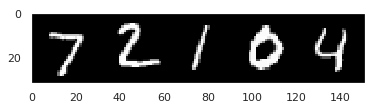

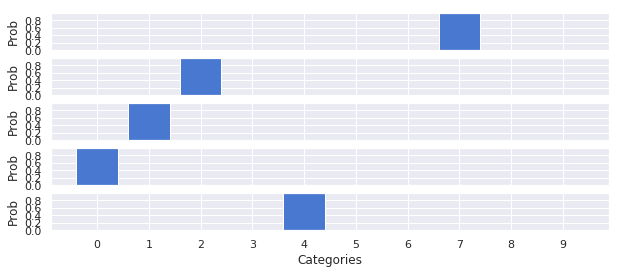

In [11]:
images, labels = iter(test_loader).next()
images, labels = images[:5], labels[:5]
print(labels)
sns.set_style("dark")
show(make_grid(images.cpu()))
probability_set = prob_distribution(images,ckpts)
prob_plot(probability_set)

### Out-Domain Distribution - Fashion MNIST

tensor([3, 6, 7, 2, 7])


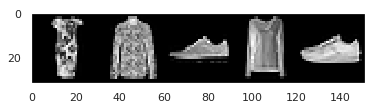

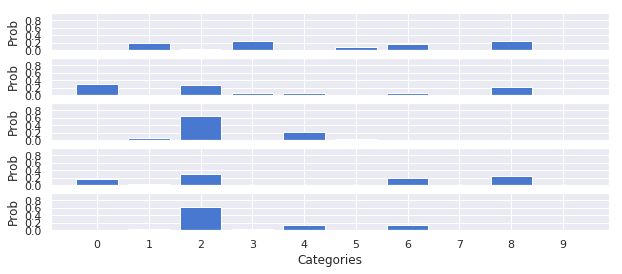

In [12]:
images, labels = iter(test_loader_f).next()
start=100
images, labels = images[start:start+5], labels[start:start+5]
print(labels)
sns.set_style("dark")
show(make_grid(images.cpu()))
probability_set = prob_distribution(images,ckpts)
prob_plot(probability_set)

### Out-Domain Distribution - notMNIST

tensor([5, 5, 5, 5, 5])


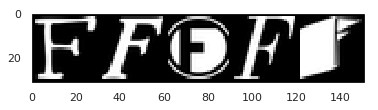

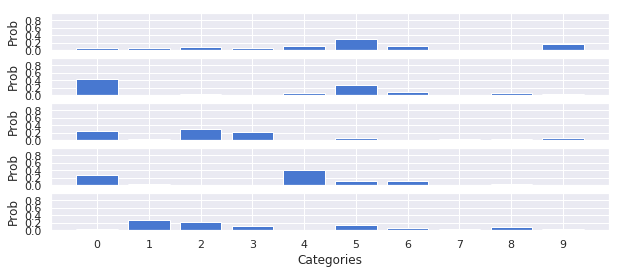

In [13]:
images, labels = iter(test_loader_not).next()
start = 120
images, labels = images[start:start+5], labels[start:start+5]
print(labels)
sns.set_style("dark")
show(make_grid(images.cpu()))
probability_set = prob_distribution(images,ckpts)
prob_plot(probability_set)

## Quantitative measure for Uncertainty

# **MC Dropout**
\begin{align}
p(y|x,D) &= \int{}p(y|x,\theta)p(\theta|D)d\theta \\
&\approx \int{}p(y|x,\theta)q(\theta)d\theta \\ 
&\approx \frac{1}{M}\sum_{m=1}^{M}p(y|x,\theta_m)
\end{align}

inference probability over the class $c$ given model $m$ can be writen as $p(y=c|x,\theta_m) = p_c^m $

In [14]:
images, labels = iter(test_loader_not).next()
probability_set = prob_distribution(images,ckpts)
print(probability_set.shape)

(47, 459, 10)


**Entropy**
\begin{align}
\mathbb{H}\left[ y|x,D \right] &= -\sum_{c}p(y=c|x,D) \space logp(y=c|x,D) \\
&= -\sum_{c} \big[ \big( \frac{1}{M}\sum_{m}p_c^m \big) \space 
               log \big( \frac{1}{M}\sum_{m}p_c^m \big) \big]
\end{align}


In [15]:
mc = probability_set.mean(axis=0)
entropy_per_image = np.sum(-mc*np.log(mc),axis=1)
entropy_total = entropy_per_image.mean()
print(entropy_total)

1.5006255367642376


**BALD** : mutual information between posterior and prediction

\begin{align}
\mathbb{I}\left[ \theta, y|x,D \right] &= \mathbb{H}\left[ y|x,D \right] - 
                                \mathbb{E}_{p(\theta|D)}\big[ \mathbb{H} \left[ y|x,\theta \right] \big] \\
&= -\sum_{c} \big[ \big( \frac{1}{M}\sum_{m=1}^{M}p_c^m \big) \space 
               log \big( \frac{1}{M}\sum_{m=1}^{M}p_c^m \big) \big] 
    + \frac{1}{M}\sum_{c}\sum_{m}p_c^m \space logp_c^m
\end{align}


In [16]:
latter = np.sum(probability_set*np.log(probability_set),axis=(2,0)) / len(ckpts)
bald_per_image = entropy_per_image + latter
bald_total = bald_per_image.mean()
print(bald_total)

1.145060508523633


**Variation Ratios**

\begin{align}
variation\_ratios(x) &= 1-\max_{c}p(y=c|x,D) \\
                    &= 1-\max_{c} \big( \frac{1}{M}\sum_{m}p_c^m \big)
\end{align}

In [17]:
mc = probability_set.mean(axis=0)
vr_per_image = 1- mc.max(axis=1)
vr_total = vr_per_image.mean()
print(vr_total)

0.578811266010462
